In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# mnist-Modified National Institute of Standards and Technology database
# it is a large database of handwritten digits that is commonly used for training various image processing systems
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/content/drive/My Drive/Colab Notebooks/MNIST/mnist_krishnaik",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/drive/My Drive/Colab Notebooks/MNIST/mnist_krishnaik/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/drive/My Drive/Colab Notebooks/MNIST/mnist_krishnaik/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /content/drive/My Drive/Colab Notebooks/MNIST/mnist_krishnaik/t10k-images-idx3-ubyte.gz
Extracting /content/drive/My Drive/Colab Notebooks/MNIST/mnist_krishnaik/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


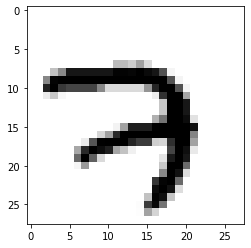

In [4]:
plt.imshow(mnist.train.images[0].reshape(28,28),cmap='Greys')




The Generator

In [0]:
def generator(z,reuse=None):   # z is the latent data point 
    with tf.variable_scope('gen',reuse=reuse):   # variable scope is gen
        hidden1 = tf.layers.dense(inputs=z,units=128) # 1st hidden layer and units is how many neurons
        # Leaky Relu     
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)


        hidden2 = tf.layers.dense(inputs=hidden1,units=128) # 2nd hidden layer
        hidden2 = tf.maximum(alpha*hidden2,hidden2) # leaky relu

        output = tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh) # output layer  784=28*28(image size)
        return output                       # tanh activation function to the output layer

The Discriminator

In [0]:
def discriminator(X,reuse=None):   # same as generator
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        
        logits = tf.layers.dense(hidden2,units=1)
        output = tf.sigmoid(logits) # here we use sigmoid function(only 2 outcomes ie. 0 or 1)
    
        return output, logits   # it gives 2 outputs one is logits value and 2nd is image is real or ake


Placeholders

In [0]:
real_images = tf.placeholder(tf.float32,shape=[None,784])# creates the place holder which gives images to the descriminator  
# tf.float32 because mnist are numpy arrays,  
# 784=28*28  one image dimension


z = tf.placeholder(tf.float32,shape=[None,100])
# creates the place holder which gives images to the generator
# z is a noise, we some noise to generator with [None,100] dimensions.


Generator

In [8]:
G = generator(z) # call the generator function

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Discriminator

In [0]:
D_output_real , D_logits_real = discriminator(real_images) # call the Discriminator function
# 1st give real_images to discriminator to train the model
# D_output_real , D_logits_real are output of discriminator on real_images  



D_output_fake, D_logits_fake = discriminator(G,reuse=True)
# after that give noise to the discriminator for testing (latent data points)
# D_output_fake, D_logits_fake are output of discriminator on latent points


Losses

In [0]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))
# loss function is help us to find out most optimat point in our training time 
#  sigmoid_cross_entropy is our loss function   

In [11]:
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real)* (0.9))
D_real_loss

# tf.ones_like(D_logits_real) gives 1 number and 0.9 indicates smoothing(near to 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [12]:
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))
D_fake_loss
# tf.zeros_like these are fake so zero(treated as fake)

<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

In [13]:
D_loss = D_real_loss + D_fake_loss
D_loss


<tf.Tensor 'add:0' shape=() dtype=float32>

In [14]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))
G_loss
# generator loss

<tf.Tensor 'Mean_2:0' shape=() dtype=float32>

optimizers

In [15]:
learning_rate = 0.001
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [16]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
D_trainer


<tf.Operation 'Adam' type=NoOp>

In [17]:
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)
G_trainer


<tf.Operation 'Adam_1' type=NoOp>

In [0]:
# Training Session

batch_size = 100
epochs = 500
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=g_vars)

In [19]:

# Save a sample per epoch
samples = []



with tf.Session() as sess:
    
    sess.run(init)
    
    # Recall an epoch is an entire run through the training data
    for e in range(epochs):
        # // indicates classic division
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            # Grab batch of images
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # Run optimizers, no need to save outputs, we won't use them
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
        
            
        print("Currently on Epoch {} of {} total...".format(e+1, epochs))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z ,reuse=True),feed_dict={z: sample_z})
        
        samples.append(gen_sample)
        
        saver.save(sess,'/content/drive/My Drive/Colab Notebooks/MNIST/model_500_epoch_model_ckpt/500_epoch_model.ckpt')

Currently on Epoch 1 of 500 total...
Currently on Epoch 2 of 500 total...
Currently on Epoch 3 of 500 total...
Currently on Epoch 4 of 500 total...
Currently on Epoch 5 of 500 total...
Currently on Epoch 6 of 500 total...
Currently on Epoch 7 of 500 total...
Currently on Epoch 8 of 500 total...
Currently on Epoch 9 of 500 total...
Currently on Epoch 10 of 500 total...
Currently on Epoch 11 of 500 total...
Currently on Epoch 12 of 500 total...
Currently on Epoch 13 of 500 total...
Currently on Epoch 14 of 500 total...
Currently on Epoch 15 of 500 total...
Currently on Epoch 16 of 500 total...
Currently on Epoch 17 of 500 total...
Currently on Epoch 18 of 500 total...
Currently on Epoch 19 of 500 total...
Currently on Epoch 20 of 500 total...
Currently on Epoch 21 of 500 total...
Currently on Epoch 22 of 500 total...
Currently on Epoch 23 of 500 total...
Currently on Epoch 24 of 500 total...
Currently on Epoch 25 of 500 total...
Currently on Epoch 26 of 500 total...
Currently on Epoch 27

In [20]:
saver = tf.train.Saver(var_list=g_vars)

new_samples = []
with tf.Session() as sess:
    
    saver.restore(sess,'/content/drive/My Drive/Colab Notebooks/MNIST/model_500_epoch_model_ckpt/500_epoch_model.ckpt')
    
    for x in range(5):
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        new_samples.append(gen_sample)


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Colab Notebooks/MNIST/model_500_epoch_model_ckpt/500_epoch_model.ckpt


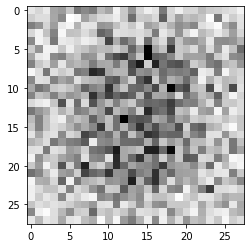

In [21]:
plt.imshow(samples[0].reshape(28,28),cmap='Greys')

